In [1]:
import numpy as np 
import pandas as pd 
import os
os.environ['KERAS_BACKEND'] = "plaidml.keras.backend"

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM ,Dropout ,CuDNNLSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import load_model,model_from_json
import re
import keras
import ast
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pickle
from sklearn.metrics import confusion_matrix, classification_report
import util
import embeddings
import ast

Using plaidml.keras.backend backend.


In [2]:
df = pd.read_csv('./data/collections_all_old/collections_all_science_out-temp_lda.csv')

In [3]:
df['lda_topics'] = df.lda_topics.apply(lambda x : [b for b in ast.literal_eval(x) ])
df['avg_word_emb'] = df.Summarization.apply(lambda x: embeddings.get_doc_embedding_avg(x,100))
df['doc_emb'] = df.Summarization.apply(lambda x: embeddings.get_Doc2vec_embedding(x,100))

In [4]:
df_v = util.generate_valid_collections_df(util.generate_collections(df))

In [5]:
df_iv = util.generate_random_collections_df(util.generate_random_collections(df,1500,5))

In [6]:
print(df_v.shape,df_iv.shape)

(1393, 10) (1500, 10)


In [7]:
final = shuffle(pd.concat([df_v,df_iv],ignore_index=True),random_state = 2019)

In [8]:
final.doc_embs.iloc[0][0].shape

(100,)

In [9]:
def prepare_data(df):
    window_size = 5
    frame = []
    label = []
    features = ["avg_word_embs", "doc_embs", "lda_topicss"]
    for index,row in df.iterrows():
        for i in range(0,len(row["lda_topicss"]) - window_size + 1):
            temp = []
            data1 = []
            data2 = []
            data3 = []
            data4 = []
            data5 = []

            for feature in features:
                data1.append(row[feature][i])
                data2.append(row[feature][i+1])
                data3.append(row[feature][i+2])
                data4.append(row[feature][i+3])
                data5.append(row[feature][i+4])
            
            data1 = [item for sublist in data1 for item in sublist]
            data2 = [item for sublist in data2 for item in sublist]
            data3 = [item for sublist in data3 for item in sublist]
            data4 = [item for sublist in data4 for item in sublist]
            data5 = [item for sublist in data5 for item in sublist]
            
            temp.append(data1)
            temp.append(data2)                
            temp.append(data3)                
            temp.append(data4)                
            temp.append(data5)                
            frame.append(temp) 
            label.append(row["label"])
    return np.array(frame),np.array(label)

In [10]:
X,y = prepare_data(final)

In [11]:
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.30, random_state=2019)

In [12]:
X_train.shape,X_test.shape

((1798, 5, 220), (771, 5, 220))

In [44]:
model = Sequential()

model.add(LSTM(
    128,
    input_shape=(X_train.shape[1:]),
    activation='relu',
    kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
    return_sequences = True))
# model.add(Dropout(0.2))

model.add(LSTM(128,activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))

# model.add(Dense(16,activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(2,activation='softmax'))

opt = keras.optimizers.Adam(lr=1e-4)
loss = keras.losses.sparse_categorical_crossentropy
model.compile(loss = loss, optimizer = opt, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 5, 128)            178688    
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_20 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
__________

In [45]:
history = model.fit(
    X_train,Y_train,
    epochs = 100 , 
    validation_data = (X_test,Y_test),
    batch_size = 64)

Train on 1798 samples, validate on 771 samples
Epoch 1/100
1798/1798 [==============================] - 1s 553us/step - loss: 53.0779 - acc: 0.5184 - val_loss: 51.2243 - val_acc: 0.6680
Epoch 2/100
1798/1798 [==============================] - 1s 439us/step - loss: 49.6390 - acc: 0.6435 - val_loss: 47.8531 - val_acc: 0.7393
Epoch 3/100
1798/1798 [==============================] - 1s 403us/step - loss: 46.3301 - acc: 0.6335 - val_loss: 44.6103 - val_acc: 0.7134
Epoch 4/100
1798/1798 [==============================] - 1s 401us/step - loss: 43.1470 - acc: 0.6546 - val_loss: 41.4932 - val_acc: 0.7263
Epoch 5/100
1798/1798 [==============================] - 1s 412us/step - loss: 40.0907 - acc: 0.6713 - val_loss: 38.5027 - val_acc: 0.7224
Epoch 6/100
1798/1798 [==============================] - 1s 404us/step - loss: 37.1621 - acc: 0.6669 - val_loss: 35.6357 - val_acc: 0.7250
Epoch 7/100
1798/1798 [==============================] - 1s 408us/step - loss: 34.3560 - acc: 0.6758 - val_loss: 32.891

Epoch 60/100
1798/1798 [==============================] - 1s 439us/step - loss: 0.6352 - acc: 0.7536 - val_loss: 0.5961 - val_acc: 0.7769
Epoch 61/100
1798/1798 [==============================] - 1s 433us/step - loss: 0.6343 - acc: 0.7564 - val_loss: 0.5968 - val_acc: 0.7808
Epoch 62/100
1798/1798 [==============================] - 1s 429us/step - loss: 0.6144 - acc: 0.7786 - val_loss: 0.5852 - val_acc: 0.7899
Epoch 63/100
1798/1798 [==============================] - 1s 442us/step - loss: 0.6175 - acc: 0.7759 - val_loss: 0.5769 - val_acc: 0.7925
Epoch 64/100
1798/1798 [==============================] - 1s 420us/step - loss: 0.6077 - acc: 0.7842 - val_loss: 0.6148 - val_acc: 0.7639
Epoch 65/100
1798/1798 [==============================] - 1s 441us/step - loss: 0.6373 - acc: 0.7653 - val_loss: 0.5806 - val_acc: 0.7951
Epoch 66/100
1798/1798 [==============================] - 1s 441us/step - loss: 0.6089 - acc: 0.7747 - val_loss: 0.5808 - val_acc: 0.7873
Epoch 67/100
1798/1798 [==========

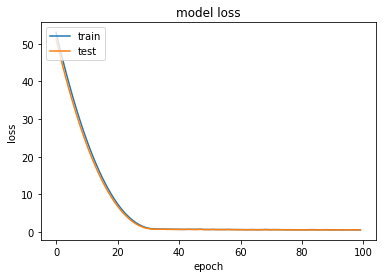

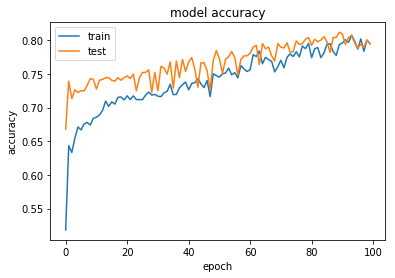

In [46]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize accuracy for loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
model.save("./data/validator_model/ws5_13_new_best_no_ovf.h5")

In [88]:
with open("./data/validator_model/Validator_windowsize_5_archi7_new.json", 'r') as f:
    model_ = model_from_json(f.read())
model_.load_weights('./data/validator_model/Validator_windowsize_5_weights7_new.h5')

In [144]:
model_ = load_model('./data/validator_model/ws5_9_new_best.h5')

In [154]:
model_.optimizer.get_config()

{'lr': 0.0010000000474974513,
 'beta_1': 0.8999999761581421,
 'beta_2': 0.9990000128746033,
 'decay': 0.0,
 'epsilon': 1e-07,
 'amsgrad': False}

In [145]:
print(model_.summary())
Y_pred = model_.predict_classes(X_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 5, 128)            178688    
_________________________________________________________________
dropout_69 (Dropout)         (None, 5, 128)            0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_70 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_71 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                1056      
__________

In [47]:
Y_pred = model.predict_classes(X_test)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       455
           1       0.75      0.76      0.75       316

   micro avg       0.80      0.80      0.80       771
   macro avg       0.79      0.79      0.79       771
weighted avg       0.80      0.80      0.80       771



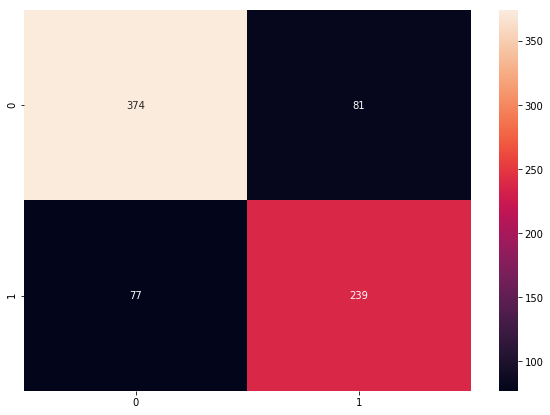

In [48]:
array = confusion_matrix(Y_test, Y_pred)
df_cm = pd.DataFrame(array, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt="d")
print(classification_report(Y_test, Y_pred))

In [49]:
model.evaluate(X_test,Y_test)

771/771 [==============================] - 2s 3ms/step


[0.5771784012419704, 0.7950713360046753]